In [1]:
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pathlib as pl
import xarray as xr
import efc

In [2]:
base_dir = pl.Path(r'C:\Users\ahaj.GS\nhm_pestpp\NHM_extractions\20230110_pois_haj\05431486')

# Full path to source streamflow netcdf file
streamflow_file = base_dir / r'sf_data.nc'

# Full path to output netcdf file
output_filename = base_dir / r'sf_data_with_EFC.nc'

In [17]:
# Helper functions for plotting, developed by P.A. Norton, USGS Dakota Water Science Center
def plot_efc(df, flow_col):
    fig, ax = plt.subplots(nrows=1, figsize=(15, 5), layout='tight')
    
    mkrsize = 9.1
    
    # cmap = ListedColormap(['#000000', '#cb4335', '#f8c471', '#95a5a6', '#76d7c4', '#154360'])
    cmap = ['#000000', '#cb4335', '#f8c471', '#95a5a6', '#76d7c4', '#154360']
    labels = ['', 'Large flood', 'Small flood', 'High flow pulse', 'Low flow', 'Extreme low flow']
    
    ax.plot(df.index, df[flow_col], c='grey', lw=.5, alpha=0.5)
    
    for xx in range(1,6):
        sdf = df[df['efc'] == xx]
        
        if sdf.shape[0] != 0:
            ax.scatter(sdf.index, sdf[flow_col], c=cmap[xx], s=mkrsize, lw=0, alpha=0.7, label=labels[xx])

    ax.set_title('Extreme flood classifications', fontsize=10)
    ax.legend(loc='upper left', framealpha=0.5)


def plot_high_low(df, flow_col):
    fig, ax = plt.subplots(nrows=1, figsize=(15, 5), layout='tight')
    
    mkrsize = 9.1
    
    cmap = ['', '#00cc66','#ff9933','#9933ff']
    labels = ['', 'Low flow', 'Ascending limb', 'Descending limb']
    
    ax.plot(df.index, df[flow_col], c='grey', lw=.5, alpha=0.5)
    
    for xx in range(1,4):
        sdf = df[df['high_low'] == xx]
        
        if sdf.shape[0] != 0:
            ax.scatter(sdf.index, sdf[flow_col], c=cmap[xx], s=mkrsize, lw=0, alpha=0.7, label=labels[xx])

    ax.set_title('High/Low classifications', fontsize=10)
    ax.legend(loc='upper left', framealpha=0.5)    

In [18]:
# Attributes for the EFC-related variables
attributes = {'efc': {'dtype': np.int32,
                      'attrs': {'long_name': 'Extreme flood classification',
                                '_FillValue': -1, 
                                'valid_range': [1, 5],
                                'flag_values': [1, 2, 3, 4, 5],
                                'flag_meanings': 'large_flood small_flood high_flow_pulse low_flow extreme_low_flow'}
                     },
              'ri': {'dtype': np.float32,
                     'attrs': {'long_name': 'Recurrence interval',
                               '_FillValue': 9.96921e+36,
                               'units': 'year'}
                    },
              'high_low': {'dtype': np.int32,
                           'attrs': {'long_name': 'Discharge classification',
                                     '_FillValue': -1,
                                     'valid_range': [1, 3],
                                     'flag_values': [1, 2, 3],
                                     'flag_meanings': 'low_flow ascending_limb descending_limb'}
                          }
             }

## Open the netcdf streamflow file

In [19]:
ds = xr.open_dataset(streamflow_file)
ds

<xarray.Dataset>
Dimensions:                (time: 15706, poi_id: 6)
Coordinates:
  * time                   (time) datetime64[ns] 1979-01-01 ... 2021-12-31
  * poi_id                 (poi_id) object '054310157' '05431016' ... '05431022'
Data variables:
    poi_name               (poi_id) |S50 ...
    latitude               (poi_id) float32 ...
    longitude              (poi_id) float32 ...
    drainage_area          (poi_id) float32 ...
    drainage_area_contrib  (poi_id) float32 ...
    discharge              (poi_id, time) float32 ...
Attributes:
    Description:  POI data for PRMS
    FeatureType:  timeSeries

In [20]:
%%html
<style>
table {float:left}
</style>
# this just shifts the table below to the left instead of centering on the screen.

## Add variables and attributes for EFC
| variable | Description
| -------- | -----------
| efc | Extreme flood classification |
| ri | Recurrence interval |
| high_low | high and low flow classification |

In [21]:
# Add variables and attributes for EFC-related variables
var_enc = {}

for var, info in attributes.items():
    # Add the variable
    ds[var] = xr.zeros_like(ds['discharge'], dtype=info['dtype'])
    
    var_enc[var] = {'zlib': True, 'complevel': 2}

    # Take care of the attributes
    del ds[var].attrs['units']
    
    for kk, vv in info['attrs'].items():
        if kk == '_FillValue':
            var_enc[var][kk] = vv
        else:
            ds[var].attrs[kk] = vv

# Set _FillValue encoding to None for certain variables
rem_fill = ['latitude', 'longitude', 'time']
for var in rem_fill:
    var_enc[var] = {'_FillValue': None}

## Compute EFC for all POIs

In [22]:
flow_col = 'discharge'

for pp in ds.poi_id.data:
    try: 
        df = efc.efc(ds.discharge.sel(poi_id=pp).to_dataframe(), flow_col=flow_col)

        # Add EFC values to the xarray dataset for the poi
        ds['efc'].sel(poi_id=pp).data[:] = df.efc.values
        ds['high_low'].sel(poi_id=pp).data[:] = df.high_low.values
        ds['ri'].sel(poi_id=pp).data[:] = df.ri.values
    except TypeError: 
        pass

## Plot individual POI with EFC highlighted

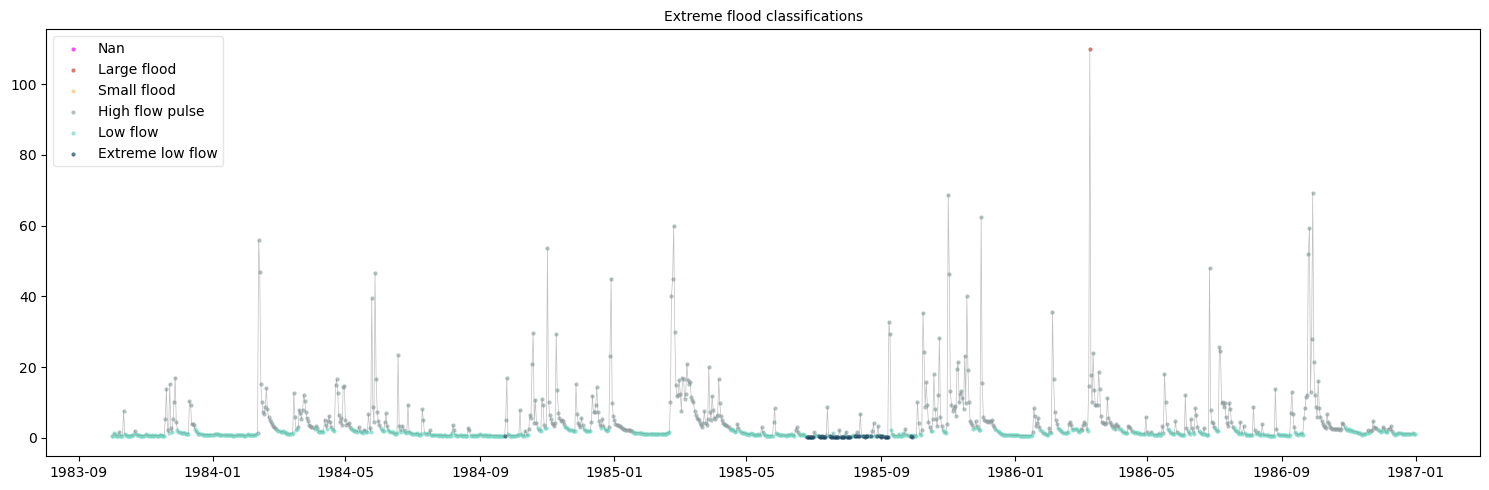

In [24]:
# Select POI
cpoi_id = '054310157'

# Get subset of data to plot
ds_sub = ds.sel(poi_id=cpoi_id, time=slice('1979-01-01', '1986-12-31')).to_dataframe()

# Or use entire dataset
#ds_sub = ds.sel(poi_id=cpoi_id).to_dataframe()

# Plot EFC
plot_efc(ds_sub, flow_col)

## Plot High/Low classifications

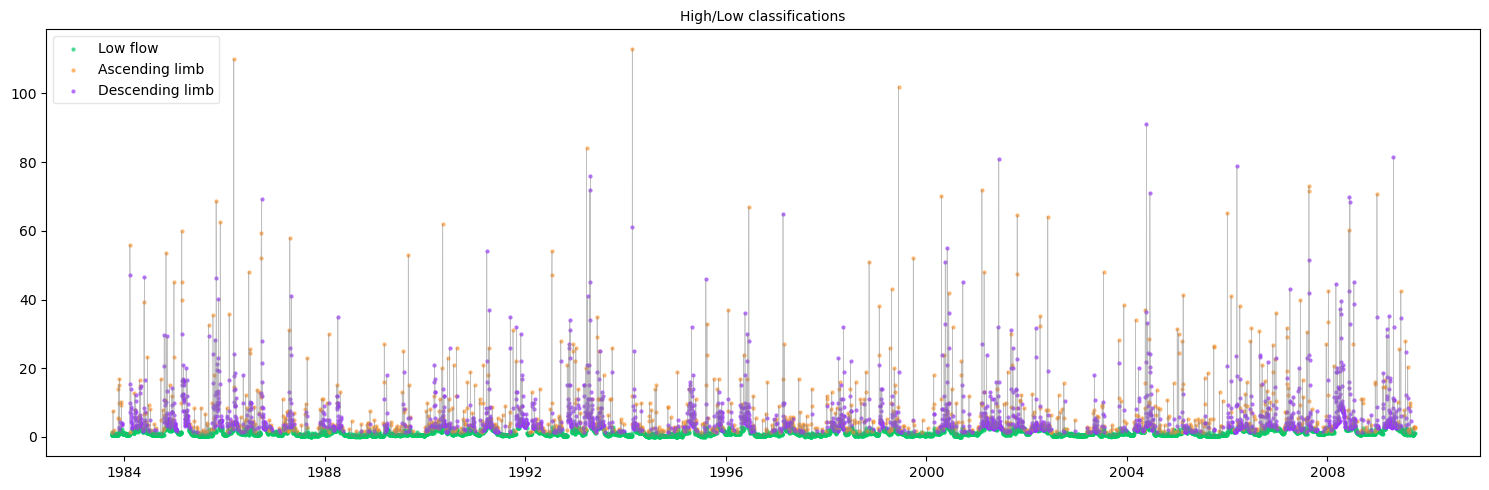

In [10]:
plot_high_low(ds_sub, flow_col)

## Write the xarray to a netcdf file

In [11]:
%%time
ds.to_netcdf(output_filename, encoding=var_enc)

CPU times: total: 953 ms
Wall time: 1.09 s


In [12]:
ds2 = xr.open_dataset(output_filename)
ds2

<xarray.Dataset>
Dimensions:                (time: 15706, poi_id: 6)
Coordinates:
  * time                   (time) datetime64[ns] 1979-01-01 ... 2021-12-31
  * poi_id                 (poi_id) object '054310157' '05431016' ... '05431022'
Data variables:
    poi_name               (poi_id) |S50 ...
    latitude               (poi_id) float32 ...
    longitude              (poi_id) float32 ...
    drainage_area          (poi_id) float32 ...
    drainage_area_contrib  (poi_id) float32 ...
    discharge              (poi_id, time) float32 ...
    efc                    (poi_id, time) float64 ...
    ri                     (poi_id, time) float32 ...
    high_low               (poi_id, time) float64 ...
Attributes:
    Description:  POI data for PRMS
    FeatureType:  timeSeries

In [13]:
ds2['efc']

<xarray.DataArray 'efc' (poi_id: 6, time: 15706)>
[94236 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-12-31
  * poi_id   (poi_id) object '054310157' '05431016' ... '05431486' '05431022'
Attributes:
    long_name:      Extreme flood classification
    valid_range:    [1 5]
    flag_values:    [1 2 3 4 5]
    flag_meanings:  large_flood small_flood high_flow_pulse low_flow extreme_...

In [14]:
ds2['efc'].values


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  4.,  4.,  4.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 4.,  4.,  4., ...,  4.,  4.,  4.],
       [nan, nan, nan, ..., nan, nan, nan]])

In [15]:
pd.unique()


NameError: name 'pd' is not defined

In [ ]:
ds2['high_low']